In [10]:
import os
import pickle as pkl

import spacy
import string
from tqdm import tqdm_notebook
from sklearn.feature_extraction import stop_words
from collections import Counter

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

import nltk
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /Users/leah/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Construct Datasets

In [3]:
path = './aclImdb'
train_path = os.path.join(path, "train")
test_path = os.path.join(path, "test")

In [4]:
def file_reader(file_name):
    """
    read a review from the train/test file
    @file_name: file directory
    """
    with open(file_name, "r") as f:
            review = f.read()
    return review 
    
def dataset_constructor(path):
    """
    construct training/testing dataset
    @path: specify it's for train file or test file
    """
    
    neg_path = os.path.join(path, "neg")
    all_neg = os.listdir(neg_path)
    pos_path = os.path.join(path, "pos")
    all_pos = os.listdir(pos_path)
    
    data = []
    label = []
    
    # known that len(all_neg) == len(all_pos)
    for i in range(0, len(all_neg)):
        data.append(file_reader(os.path.join(neg_path, all_neg[i])))
        label.append(0)
        data.append(file_reader(os.path.join(pos_path, all_pos[i])))
        label.append(1)
        
    return data, label 

In [5]:
train_data, train_label = dataset_constructor(train_path)
test_data, test_label = dataset_constructor(test_path)

In [6]:
val_size = 5000
val_data = train_data[:val_size]
val_label = train_label[:val_size]

train_data = train_data[val_size:]
train_label = train_label[val_size:]

In [7]:
print ("Train dataset size is {}".format(len(train_label)))
print ("Val dataset size is {}".format(len(val_label)))
print ("Test dataset size is {}".format(len(test_label)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


### Bag of N-gram

In [97]:
# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

def ngram_extractor(dataset, k, remove_stopwords = True, lemma = True):
    """
    Extract all ngram from a review where n<=k, and preprocess 
    @review: the dataset full of raw text/review
    @k: an integer to indicate the model needs to get all ngram where n<=k
    @remove_stopwords: boolean, default to be True
    """
    ngram_dataset = [] # a list of list, each list is a review 
    all_ngram = [] # a list of string
    
    # tokenize and  preprocess all the tokens
    for review in tqdm_notebook(tokenizer.pipe(dataset, disable=['parser', 'tagger', 'ner'], batch_size=512, n_threads=1)):
        
        tokens = [token.text.lower().replace("<br />", "") for token in review if (token.text not in punctuations)]
        
        # remove stop words
        if remove_stopwords:
            tokens = [token for token in tokens if token not in stop_words.ENGLISH_STOP_WORDS]
        # e.g. review = "no one is listening"
        #      tokens = ["no","one","is","listening"]
        
        # word lemmatization
        if lemma:
            lmtzr = WordNetLemmatizer()
            tokens = [lmtzr.lemmatize(token) for token in tokens]
            # e.g. review = "cars car"
            #      tokens = ["car", "car"]
        
        # retrieve all k-grams where k<=n
        review_ngram = []
        for n in range(k):
            for i in range(len(tokens)-n):
                ngram = " ".join(tokens[i:i+n+1])
                review_ngram.append(ngram)
        
        ngram_dataset.append(review_ngram)
        all_ngram += review_ngram

    return ngram_dataset, all_ngram

In [139]:
# train set ngrams
k = 4
print("Tokenizing training data and save it to pickle...")
train_ngram_dataset, all_train_ngram = ngram_extractor(train_data, k)
pkl.dump(train_ngram_dataset, open(str(k)+"train_ngram_dataset.p", "wb"))
pkl.dump(all_train_ngram, open(str(k)+"all_train_ngram.p", "wb"))
print("Done for training data!")

Tokenizing training data and save it to pickle...



Done for training data!


In [157]:
# val set ngrams
k = 1
print("Tokenizing validation data and save it to pickle...")
val_ngram_dataset, _ = ngram_extractor(val_data, k)
pkl.dump(val_ngram_dataset, open(str(k)+"val_ngram_dataset.p", "wb"))
print("Done for validation data!")

Tokenizing validation data and save it to pickle...



Done for validation data!


In [141]:
# test set ngrams
k = 4
print("Tokenizing testing data and save it to pickle...")
test_ngram_dataset, _ = ngram_extractor(test_data, k)
pkl.dump(test_ngram_dataset, open(str(k)+"test_ngram_dataset.p", "wb"))
print("Done for testing data!")

Tokenizing testing data and save it to pickle...



Done for testing data!


### Read pickle files

In [303]:
k = 1
train_ngram_dataset = pkl.load(open(str(k) + "train_ngram_dataset.p", "rb"))
all_train_ngram = pkl.load(open(str(k) + "all_train_ngram.p", "rb"))

val_ngram_dataset = pkl.load(open(str(k) + "val_ngram_dataset.p", "rb"))
test_ngram_dataset = pkl.load(open(str(k) + "test_ngram_dataset.p", "rb"))

In [304]:
print ("Train dataset size is {}".format(len(train_ngram_dataset)))
print ("Val dataset size is {}".format(len(val_ngram_dataset)))
print ("Test dataset size is {}".format(len(test_ngram_dataset)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_ngram)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 2339815


In [350]:
vocab_size = 25000 # only consider about the topk 
PAD_IDX = 0
UNK_IDX = 1  # for the words which are not belong to the topk vocab 

def vocab_builder(all_ngrams, vocab_size):
    """
    selects the most common top k ngrams
    @all_ngram: a list of ngrams
    @vocab_size: a integer to indicate the topk
    Returns:
    ngram2id: dictionary where keys represent ngram and corresponding value s represent indices
    id2ngram: list of ngram, where id2ngram[i] returns ngram that corresponds to ngram i
    """
    ngram_counter = Counter(all_ngrams)
    topk = ngram_counter.most_common(vocab_size)
    vocab, count = zip(*topk)
    id2ngram = list(vocab)
    ngram2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2ngram = ['<pad>', '<unk>'] + id2ngram
    ngram2id['<pad>'] = PAD_IDX 
    ngram2id['<unk>'] = UNK_IDX
    
    return ngram2id, id2ngram

In [351]:
ngram2id, id2ngram = vocab_builder(all_train_ngram, vocab_size)

In [352]:
# double checking
print ("ngram2id size is {}".format(len(ngram2id)))
print ("id2ngram size is {}".format(len(id2ngram)))

ngram2id size is 25002
id2ngram size is 25002


In [353]:
def ngram_indexer(ngrams_data):
    """
    transform a list (review) of ngram to a list of ngram index
    @ngram_dataset: a list of list, each list element contains all ngrams for a single review
    Returns:
    indices_data: a list of list, now the ngram's are changed to their own index
    """
    indices_data = []
    for review in ngrams_data:
        
        index_list = [ngram2id[ngram] if ngram in ngram2id else UNK_IDX for ngram in review]
        indices_data.append(index_list)
        
    return indices_data

In [354]:
train_data_indices = ngram_indexer(train_ngram_dataset)
val_data_indices = ngram_indexer(val_ngram_dataset)
test_data_indices = ngram_indexer(test_ngram_dataset)

In [355]:
# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


### Input Pipeline for PyTorch

In [356]:
max_sent_length = 1000

class ReviewDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """ 
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of IMDB reviews (ngrams)
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        token_idx = self.data_list[key][:max_sent_length]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

In [357]:
def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,max_sent_length-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), 
            torch.LongTensor(length_list), 
            torch.LongTensor(label_list)]

In [358]:
# create datasets
review_train = ReviewDataset(train_data_indices, train_label)
review_val = ReviewDataset(val_data_indices, val_label)
review_test = ReviewDataset(test_data_indices, test_label)

In [359]:
# construct data loader
batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=review_train, 
                                           batch_size=batch_size,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=review_val, 
                                           batch_size=batch_size,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=review_test, 
                                           batch_size=batch_size,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

### Define Bag-of-Ngram Model

In [360]:
class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """  
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
        out = self.linear(out.float())
        
        return out

In [369]:
emb_dim = 75
model = BagOfWords(len(id2ngram), emb_dim)

In [370]:
learning_rate = 0.001
#num_epochs = 20 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
#criterion = torch.nn.BCELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [371]:
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [372]:
# Training the Model for adam
num_epochs = 15
loss_store_f = []
train_acc_store_f = []
val_acc_store_f = []
for epoch in range(num_epochs):
    epoch_loss_lst =[]
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        epoch_loss_lst.append(loss)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # training loss
            train_acc = test_model(train_loader, model)
            train_acc_store_f.append(train_acc)
            # validate
            val_acc = test_model(val_loader, model)
            val_acc_store_f.append(val_acc)
            #print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
            #           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
            print('Epoch: [{}/{}], Step: [{}/{}], Training Acc: {}, Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc))
    loss_store_f.append(sum(epoch_loss_lst))
    #train_acc_store_1.append(train_acc)
    #val_acc_store_1.append(val_acc)

Epoch: [1/15], Step: [101/625], Training Acc: 64.175, Validation Acc: 64.14
Epoch: [1/15], Step: [201/625], Training Acc: 71.915, Validation Acc: 71.74
Epoch: [1/15], Step: [301/625], Training Acc: 76.295, Validation Acc: 75.76
Epoch: [1/15], Step: [401/625], Training Acc: 79.69, Validation Acc: 79.7
Epoch: [1/15], Step: [501/625], Training Acc: 82.03, Validation Acc: 81.0
Epoch: [1/15], Step: [601/625], Training Acc: 84.13, Validation Acc: 83.44
Epoch: [2/15], Step: [101/625], Training Acc: 85.84, Validation Acc: 84.66
Epoch: [2/15], Step: [201/625], Training Acc: 87.025, Validation Acc: 85.56
Epoch: [2/15], Step: [301/625], Training Acc: 87.965, Validation Acc: 86.38
Epoch: [2/15], Step: [401/625], Training Acc: 88.67, Validation Acc: 86.82
Epoch: [2/15], Step: [501/625], Training Acc: 89.29, Validation Acc: 87.16
Epoch: [2/15], Step: [601/625], Training Acc: 89.83, Validation Acc: 87.28
Epoch: [3/15], Step: [101/625], Training Acc: 90.73, Validation Acc: 87.78
Epoch: [3/15], Step: [

In [373]:
print ("Test Acc {}".format(test_model(test_loader, model))) 

Test Acc 84.584


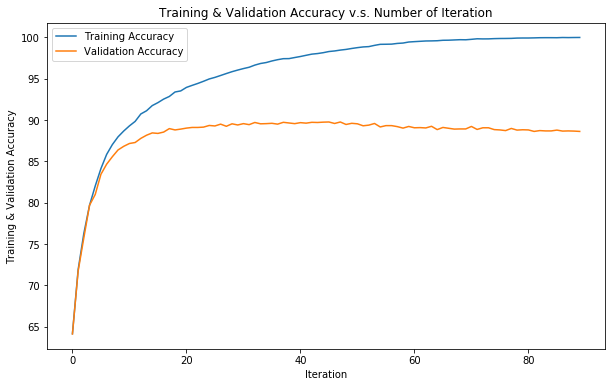

In [374]:
# validation accuracy for tokenization schemas
fig, ax = plt.subplots(figsize=(10,6)) #figsize=(10,6)
ax.set_xlabel('Iteration')
ax.set_ylabel('Training & Validation Accuracy')
ax.set_title("Training & Validation Accuracy v.s. Number of Iteration")
plt.plot(train_acc_store_f, label="Training Accuracy")
plt.plot(val_acc_store_f, label="Validation Accuracy")
plt.legend(loc="best")
plt.savefig("final.png")
plt.show()

No handles with labels found to put in legend.


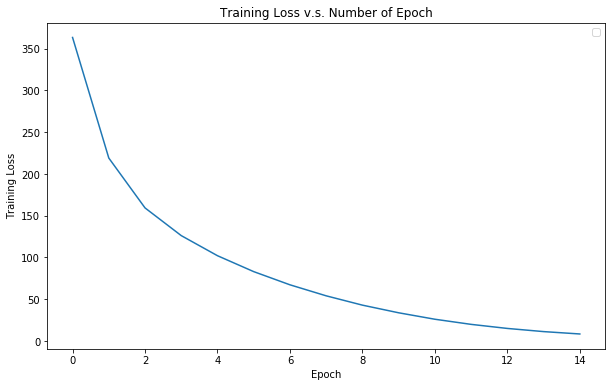

In [375]:
# validation accuracy for tokenization schemas
fig, ax = plt.subplots(figsize=(10,6)) #figsize=(10,6)
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.set_title("Training Loss v.s. Number of Epoch")
plt.plot(loss_store_f)
plt.legend(loc="best")
plt.savefig("final2.png")
plt.show()

### Pick Tokenization Schemas

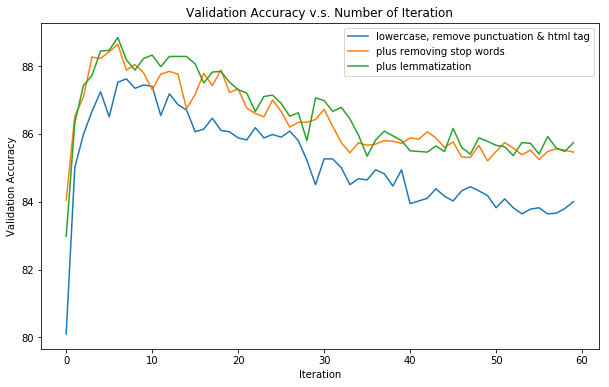

In [96]:
# validation accuracy for tokenization schemas
fig, ax = plt.subplots(figsize=(10,6)) #figsize=(10,6)
ax.set_xlabel('Iteration')
ax.set_ylabel('Validation Accuracy')
ax.set_title("Validation Accuracy v.s. Number of Iteration")
plt.plot(val_acc_store_1, label="lowercase, remove punctuation & html tag")
plt.plot(val_acc_store_2, label="plus removing stop words")
plt.plot(val_acc_store_3, label="plus lemmatization")
plt.legend(loc="best")
plt.savefig("token_schema.png")
plt.show()

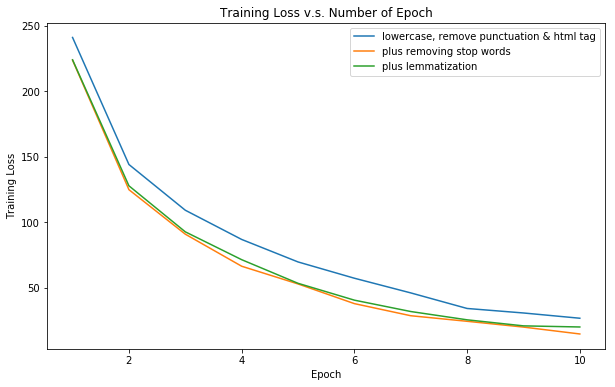

In [93]:
# traning loss for tokenization schemas
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.set_title("Training Loss v.s. Number of Epoch")
plt.plot(list(range(1, num_epochs+1)), loss_store_1, label="lowercase, remove punctuation & html tag")
plt.plot(list(range(1, num_epochs+1)), loss_store_2, label="plus removing stop words")
plt.plot(list(range(1, num_epochs+1)), loss_store_3, label="plus lemmatization")
plt.legend(loc="best")
plt.savefig("token_schema_2.png")
plt.show()

### Pick N-gram

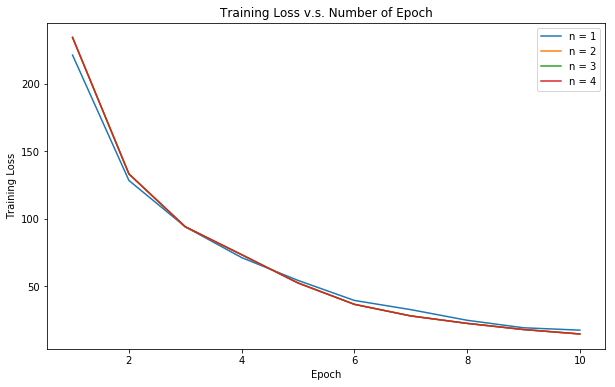

In [175]:
# training loss for ngram
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.set_title("Training Loss v.s. Number of Epoch")
plt.plot(list(range(1, num_epochs+1)), loss_store_n1, label="n = 1")
plt.plot(list(range(1, num_epochs+1)), loss_store_n2, label="n = 2")
plt.plot(list(range(1, num_epochs+1)), loss_store_n2, label="n = 3")
plt.plot(list(range(1, num_epochs+1)), loss_store_n2, label="n = 4")
plt.legend(loc="best")
plt.savefig("ngram_1.png")
plt.show()

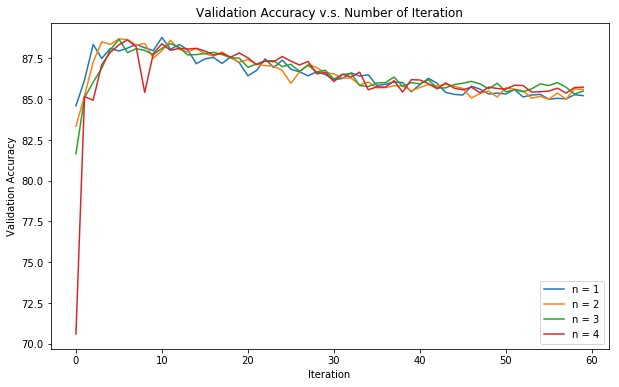

In [194]:
# validation accuracy for ngram
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Iteration')
ax.set_ylabel('Validation Accuracy')
ax.set_title("Validation Accuracy v.s. Number of Iteration")
plt.plot(val_acc_store_n1, label="n = 1")
plt.plot(val_acc_store_n2, label="n = 2")
plt.plot(val_acc_store_n3, label="n = 3")
plt.plot(val_acc_store_n4, label="n = 4")
plt.legend(loc="best")
plt.savefig("ngram_2.png")
plt.show()

### Hyperparameters Tuning and Plotting

In [137]:
# the function for training the Model 
# good for getting data for plot
def train_model(model, optimizer, criterion, train_loader, val_loader, num_epochs):
    
    loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_acc = val_acc = 0
    
    for epoch in range(num_epochs):
        epoch_loss_lst =[]
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            epoch_loss_lst.append(loss)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 300 == 0:
                # training accuracy
                train_acc = test_model(train_loader, model)
                # validate accuracy
                val_acc = test_model(val_loader, model)
                #print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                #           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
                print('Epoch: [{}/{}], Step: [{}/{}], Training Acc: {}, Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc))
        
        loss_hist.append(sum(epoch_loss_lst))
        train_acc_hist.append(train_acc)
        val_acc_hist.append(val_acc)
        
    return loss_hist, train_acc_hist, val_acc_hist

In [147]:
model = BagOfWords(len(id2ngram), emb_dim)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.03, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 50
sgd_loss, sgd_train_acc, sgd_val_acc = train_model(model, optimizer, criterion, 
                                                   train_loader, val_loader, num_epochs)

Epoch: [1/50], Step: [201/625], Training Acc: 64.45, Validation Acc: 64.74
Epoch: [1/50], Step: [401/625], Training Acc: 65.88, Validation Acc: 66.86
Epoch: [1/50], Step: [601/625], Training Acc: 66.605, Validation Acc: 67.04
Epoch: [2/50], Step: [201/625], Training Acc: 68.86, Validation Acc: 70.34
Epoch: [2/50], Step: [401/625], Training Acc: 67.92, Validation Acc: 68.68
Epoch: [2/50], Step: [601/625], Training Acc: 70.405, Validation Acc: 71.92
Epoch: [3/50], Step: [201/625], Training Acc: 70.95, Validation Acc: 71.86
Epoch: [3/50], Step: [401/625], Training Acc: 71.11, Validation Acc: 71.34
Epoch: [3/50], Step: [601/625], Training Acc: 72.195, Validation Acc: 73.3
Epoch: [4/50], Step: [201/625], Training Acc: 72.505, Validation Acc: 72.92
Epoch: [4/50], Step: [401/625], Training Acc: 71.465, Validation Acc: 72.22
Epoch: [4/50], Step: [601/625], Training Acc: 72.88, Validation Acc: 73.46
Epoch: [5/50], Step: [201/625], Training Acc: 73.93, Validation Acc: 74.86
Epoch: [5/50], Step: 

Epoch: [37/50], Step: [201/625], Training Acc: 87.09, Validation Acc: 84.28
Epoch: [37/50], Step: [401/625], Training Acc: 86.57, Validation Acc: 83.84
Epoch: [37/50], Step: [601/625], Training Acc: 87.045, Validation Acc: 84.32
Epoch: [38/50], Step: [201/625], Training Acc: 87.145, Validation Acc: 84.4
Epoch: [38/50], Step: [401/625], Training Acc: 87.34, Validation Acc: 84.34
Epoch: [38/50], Step: [601/625], Training Acc: 87.31, Validation Acc: 84.4
Epoch: [39/50], Step: [201/625], Training Acc: 87.315, Validation Acc: 84.34
Epoch: [39/50], Step: [401/625], Training Acc: 87.33, Validation Acc: 84.38
Epoch: [39/50], Step: [601/625], Training Acc: 86.95, Validation Acc: 84.22
Epoch: [40/50], Step: [201/625], Training Acc: 87.54, Validation Acc: 84.38
Epoch: [40/50], Step: [401/625], Training Acc: 87.41, Validation Acc: 84.34
Epoch: [40/50], Step: [601/625], Training Acc: 87.59, Validation Acc: 84.6
Epoch: [41/50], Step: [201/625], Training Acc: 87.61, Validation Acc: 84.34
Epoch: [41/5

In [148]:
model = BagOfWords(len(id2ngram), emb_dim)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 50
sgd_loss_1, sgd_train_acc_1, sgd_val_acc_1 = train_model(model, optimizer, criterion, 
                                                   train_loader, val_loader, num_epochs)

Epoch: [1/50], Step: [201/625], Training Acc: 62.13, Validation Acc: 62.5
Epoch: [1/50], Step: [401/625], Training Acc: 65.225, Validation Acc: 65.4
Epoch: [1/50], Step: [601/625], Training Acc: 66.15, Validation Acc: 66.5
Epoch: [2/50], Step: [201/625], Training Acc: 66.53, Validation Acc: 66.62
Epoch: [2/50], Step: [401/625], Training Acc: 67.135, Validation Acc: 67.16
Epoch: [2/50], Step: [601/625], Training Acc: 67.025, Validation Acc: 66.8
Epoch: [3/50], Step: [201/625], Training Acc: 67.645, Validation Acc: 67.54
Epoch: [3/50], Step: [401/625], Training Acc: 68.03, Validation Acc: 67.96
Epoch: [3/50], Step: [601/625], Training Acc: 68.285, Validation Acc: 68.26
Epoch: [4/50], Step: [201/625], Training Acc: 68.515, Validation Acc: 68.52
Epoch: [4/50], Step: [401/625], Training Acc: 68.935, Validation Acc: 68.86
Epoch: [4/50], Step: [601/625], Training Acc: 69.065, Validation Acc: 69.08
Epoch: [5/50], Step: [201/625], Training Acc: 69.47, Validation Acc: 69.3
Epoch: [5/50], Step: [

Epoch: [37/50], Step: [201/625], Training Acc: 80.98, Validation Acc: 79.74
Epoch: [37/50], Step: [401/625], Training Acc: 81.1, Validation Acc: 79.9
Epoch: [37/50], Step: [601/625], Training Acc: 81.13, Validation Acc: 79.8
Epoch: [38/50], Step: [201/625], Training Acc: 81.145, Validation Acc: 79.8
Epoch: [38/50], Step: [401/625], Training Acc: 81.11, Validation Acc: 79.86
Epoch: [38/50], Step: [601/625], Training Acc: 81.265, Validation Acc: 79.9
Epoch: [39/50], Step: [201/625], Training Acc: 81.105, Validation Acc: 79.86
Epoch: [39/50], Step: [401/625], Training Acc: 81.185, Validation Acc: 79.96
Epoch: [39/50], Step: [601/625], Training Acc: 81.195, Validation Acc: 79.96
Epoch: [40/50], Step: [201/625], Training Acc: 81.47, Validation Acc: 80.18
Epoch: [40/50], Step: [401/625], Training Acc: 81.46, Validation Acc: 80.1
Epoch: [40/50], Step: [601/625], Training Acc: 81.53, Validation Acc: 80.26
Epoch: [41/50], Step: [201/625], Training Acc: 81.655, Validation Acc: 80.22
Epoch: [41/5

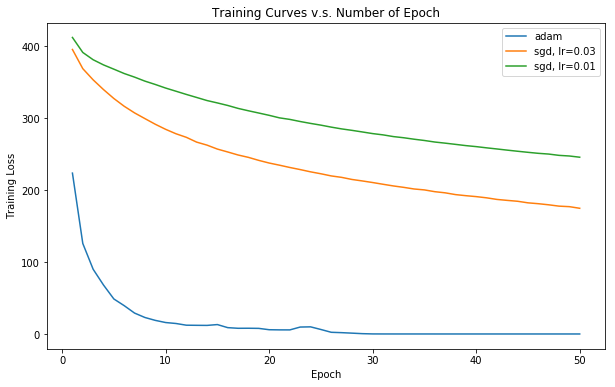

In [149]:
# draw the training loss curve
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,6)) #figsize=(10,6)
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.set_title("Training Curves v.s. Number of Epoch")
plt.plot(list(range(1, num_epochs+1)), adam_loss_store, label="adam, lr=0.01")
plt.plot(list(range(1, num_epochs+1)), sgd_loss, label="sgd, lr=0.03")
plt.plot(list(range(1, num_epochs+1)), sgd_loss_1, label="sgd, lr=0.01")
plt.legend(loc="best")
plt.savefig("adam_vs_sgd_loss_2.png")
plt.show()

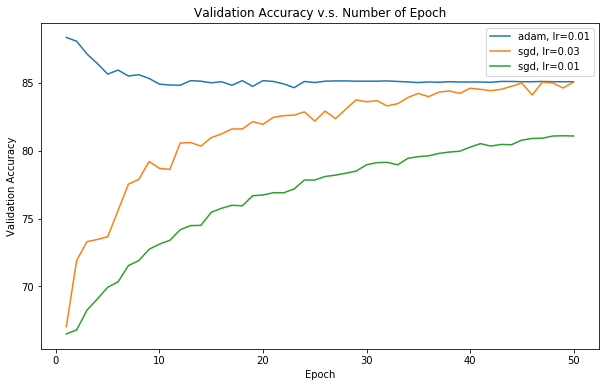

In [185]:
# validation accuracy for adam (0.01), sgd (0.01) & sgd (0.03)
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Accuracy')
ax.set_title("Validation Accuracy v.s. Number of Epoch")
plt.plot(list(range(1, num_epochs+1)), adam_val_acc_store, label = 'adam, lr=0.01')
plt.plot(list(range(1, num_epochs+1)), sgd_val_acc, label = 'sgd, lr=0.03')
plt.plot(list(range(1, num_epochs+1)), sgd_val_acc_1, label = 'sgd, lr=0.01')
plt.legend(loc="best")
#plt.savefig("adam_vs_sgd_val_acc_f.png")
plt.show()

### vocab_size [5000, 10000, 25000]

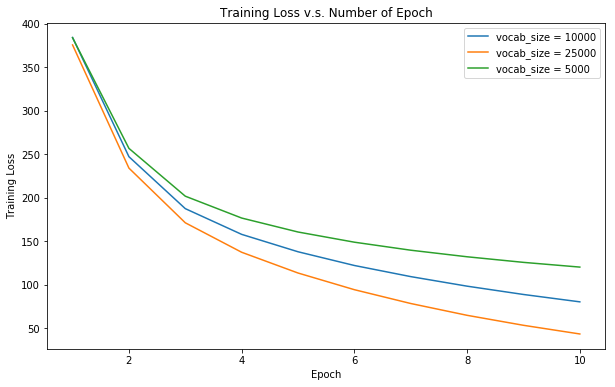

In [250]:
# training loss
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.set_title("Training Loss v.s. Number of Epoch")
plt.plot(list(range(1, num_epochs+1)), loss_store_vs1, label = 'vocab_size = 10000')
plt.plot(list(range(1, num_epochs+1)), loss_store_vs2, label = 'vocab_size = 25000')
plt.plot(list(range(1, num_epochs+1)), loss_store_vs3, label = 'vocab_size = 5000')
plt.legend(loc="best")
plt.savefig("vocab_size_loss.png")
plt.show()

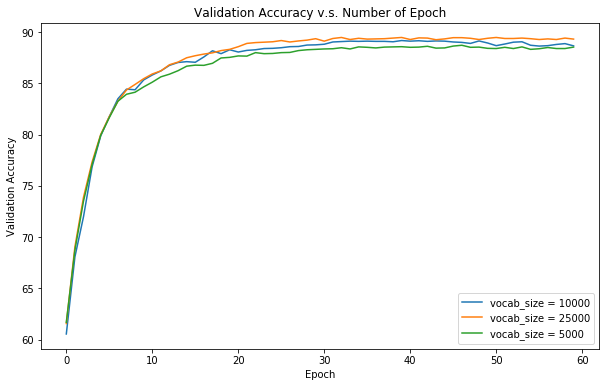

In [251]:
# validation accuracy 
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Accuracy')
ax.set_title("Validation Accuracy v.s. Number of Epoch")
plt.plot(val_acc_store_vs1, label = 'vocab_size = 10000')
plt.plot(val_acc_store_vs2, label = 'vocab_size = 25000')
plt.plot(val_acc_store_vs3, label = 'vocab_size = 5000')
plt.legend(loc="best")
plt.savefig("vocab_size_acc.png")
plt.show()

### emd_dim [50, 75, 100]

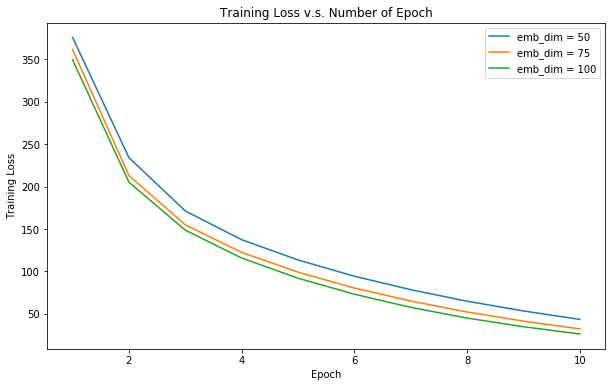

In [275]:
# training loss
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.set_title("Training Loss v.s. Number of Epoch")
plt.plot(list(range(1, num_epochs+1)), loss_store_vs2, label = 'emb_dim = 50')
plt.plot(list(range(1, num_epochs+1)), loss_store_ed2, label = 'emb_dim = 75')
plt.plot(list(range(1, num_epochs+1)), loss_store_ed3, label = 'emb_dim = 100')
plt.legend(loc="best")
plt.savefig("emb_dim_loss.png")
plt.show()

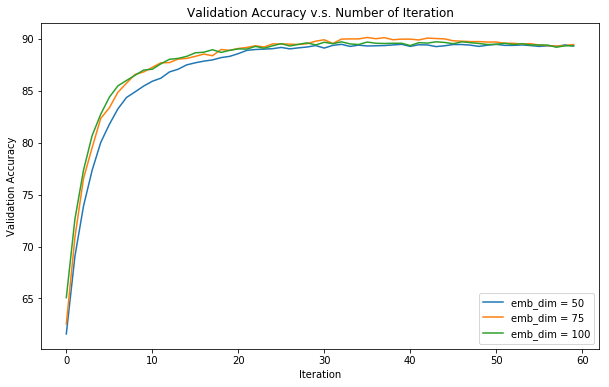

In [276]:
# validation accuracy 
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Iteration')
ax.set_ylabel('Validation Accuracy')
ax.set_title("Validation Accuracy v.s. Number of Iteration")
plt.plot(val_acc_store_vs2, label = 'emb_dim = 50')
plt.plot(val_acc_store_ed2, label = 'emb_dim = 75')
plt.plot(val_acc_store_ed3, label = 'emb_dim = 100')
plt.legend(loc="best")
plt.savefig("emb_dim_acc.png")
plt.show()

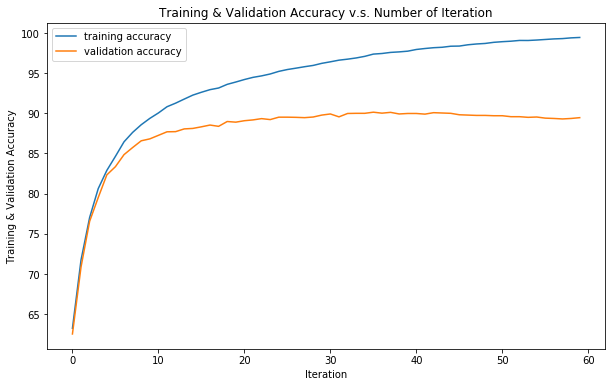

In [277]:
# overfitting
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Iteration')
ax.set_ylabel('Training & Validation Accuracy')
ax.set_title("Training & Validation Accuracy v.s. Number of Iteration")
plt.plot(train_acc_store_ed2, label = 'training accuracy')
plt.plot(val_acc_store_ed2, label = 'validation accuracy')
plt.legend(loc="best")
plt.savefig("emb_dim_tv_acc.png")
plt.show()

In [281]:
max(val_acc_store_ed2)

90.14

### Grid Search 
traverse all combinations of selected hyperparameters and save the accordingly validation accuracies to pandas DataFrame

In [201]:
vocab_size_lst = [1000, 5000, 10000] 
emb_dim_lst = [50, 100, 500]
max_sent_length_lst = [200, 500, 1000]
learning_rate_lst = [0.001, 0.005, 0.01, 0.05, 0.1]
param_dict = {"vocab_size":[], "emb_dim":[], "max_sent_length":[],
             "learning_rate":[], "val_acc":[]}

In [202]:
def get_acc(model, optimizer, criterion, train_loader, val_loader, num_epochs):
    """
    function for only computing validation accuracy after training
    """
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()

    return test_model(val_loader, model)

In [203]:
i = 0 # 135  iteration
for vocab_size in vocab_size_lst:
    for emb_dim in emb_dim_lst:
        for max_sent_length in max_sent_length_lst:
            for learning_rate in learning_rate_lst:
                
                i += 1
                print(i)
                ngram2id, id2ngram = vocab_builder(all_train_ngram, vocab_size)
                train_data_indices = ngram_indexer(train_ngram_dataset)
                val_data_indices = ngram_indexer(val_ngram_dataset)
                test_data_indices = ngram_indexer(test_ngram_dataset)
                review_train = ReviewDataset(train_data_indices, train_label)
                review_val = ReviewDataset(val_data_indices, val_label)
                review_test = ReviewDataset(test_data_indices, test_label)
                train_loader = torch.utils.data.DataLoader(dataset=review_train, 
                                                           batch_size=batch_size,
                                                           collate_fn=newsgroup_collate_func,
                                                           shuffle=True)
                val_loader = torch.utils.data.DataLoader(dataset=review_val, 
                                                         batch_size=batch_size,
                                                         collate_fn=newsgroup_collate_func,
                                                         shuffle=False)
                model = BagOfWords(len(id2ngram), emb_dim)
                criterion = torch.nn.CrossEntropyLoss()
                optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
                val_acc = get_acc(model, optimizer, criterion, 
                                  train_loader, val_loader, num_epochs = 15)
                
                param_dict["vocab_size"].append(vocab_size)
                param_dict["emb_dim"].append(emb_dim)
                param_dict["max_sent_length"].append(max_sent_length)
                param_dict["learning_rate"].append(learning_rate)
                param_dict["val_acc"].append(val_acc)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135


In [204]:
pd.DataFrame(param_dict)

,vocab_size,emb_dim,max_sent_length,learning_rate,val_acc
0,1000,50,200,0.001,84.58
1,1000,50,200,0.005,84.48
2,1000,50,200,0.010,84.36
3,1000,50,200,0.050,83.54
4,1000,50,200,0.100,82.62
5,1000,50,500,0.001,85.04
6,1000,50,500,0.005,84.66
7,1000,50,500,0.010,84.54
8,1000,50,500,0.050,84.22
9,1000,50,500,0.100,81.96


In [199]:
param_df = pd.DataFrame(param_dict)
param_df.to_csv("unigram_param_grid_search.csv")

NameError: name 'param_dict' is not defined

In [209]:
# check the parameter combination of top 10 validation accuracy
param_df.sort_values('val_acc',ascending=False)[:10]

,vocab_size,emb_dim,max_sent_length,learning_rate,val_acc
100,10000,50,1000,0.001,88.28
55,5000,50,1000,0.001,88.26
90,10000,50,200,0.001,88.24
95,10000,50,500,0.001,88.18
45,5000,50,200,0.001,87.96
50,5000,50,500,0.001,87.94
65,5000,100,500,0.001,87.86
70,5000,100,1000,0.001,87.78
110,10000,100,500,0.001,87.74
105,10000,100,200,0.001,87.70


#### Learning Rate Decay

In [300]:
# Criterion and Optimizer
num_epochs = 10

loss_store_decay2 = []
train_acc_store_decay2 = []
val_acc_store_decay2 = []

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

for epoch in range(num_epochs):
    scheduler.step()
    epoch_loss_lst = []
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        epoch_loss_lst.append(loss)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # train
            train_acc = test_model(train_loader, model)
            train_acc_store_decay2.append(train_acc)
            # validate
            val_acc = test_model(val_loader, model)
            val_acc_store_decay2.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Training Acc: {}, Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc))
    loss_store_decay2.append(sum(epoch_loss_lst))

Epoch: [1/10], Step: [101/625], Training Acc: 64.875, Validation Acc: 63.82
Epoch: [1/10], Step: [201/625], Training Acc: 73.5, Validation Acc: 71.9
Epoch: [1/10], Step: [301/625], Training Acc: 77.84, Validation Acc: 77.04
Epoch: [1/10], Step: [401/625], Training Acc: 81.295, Validation Acc: 80.38
Epoch: [1/10], Step: [501/625], Training Acc: 83.265, Validation Acc: 82.08
Epoch: [1/10], Step: [601/625], Training Acc: 85.2, Validation Acc: 83.7
Epoch: [2/10], Step: [101/625], Training Acc: 86.605, Validation Acc: 84.84
Epoch: [2/10], Step: [201/625], Training Acc: 87.54, Validation Acc: 85.58
Epoch: [2/10], Step: [301/625], Training Acc: 88.195, Validation Acc: 85.96
Epoch: [2/10], Step: [401/625], Training Acc: 88.995, Validation Acc: 86.94
Epoch: [2/10], Step: [501/625], Training Acc: 89.67, Validation Acc: 87.32
Epoch: [2/10], Step: [601/625], Training Acc: 90.435, Validation Acc: 87.5
Epoch: [3/10], Step: [101/625], Training Acc: 90.745, Validation Acc: 87.62
Epoch: [3/10], Step: [

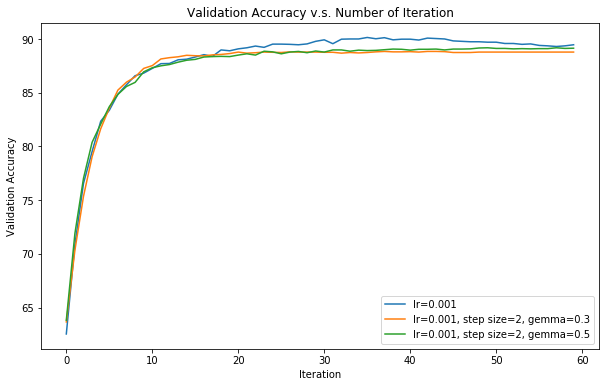

In [301]:
# validation accuracy 
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Iteration')
ax.set_ylabel('Validation Accuracy')
ax.set_title("Validation Accuracy v.s. Number of Iteration")
plt.plot(val_acc_store_ed2, label = 'lr=0.001')
plt.plot(val_acc_store_decay, label = 'lr=0.001, step size=2, gemma=0.3')
plt.plot(val_acc_store_decay2, label = 'lr=0.001, step size=2, gemma=0.5')
plt.legend(loc="best")
plt.savefig("lr_decay_acc.png")
plt.show()

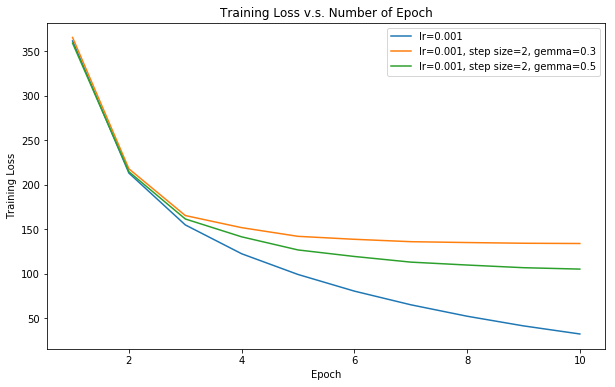

In [302]:
# training loss
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.set_title("Training Loss v.s. Number of Epoch")
plt.plot(list(range(1, num_epochs+1)), loss_store_ed2, label = 'lr=0.001')
plt.plot(list(range(1, num_epochs+1)), loss_store_decay, label = 'lr=0.001, step size=2, gemma=0.3')
plt.plot(list(range(1, num_epochs+1)), loss_store_decay2, label = 'lr=0.001, step size=2, gemma=0.5')
plt.legend(loc="best")
plt.savefig("lr_decay_loss.png")
plt.show()

### Find three correct and three incorrect examples

In [319]:
def correct_pred_finder(loader, model):
    model.eval()
    index_store = []
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1] 
        check_tensor = torch.eq(predicted.view_as(labels), labels)
        check_arr = check_tensor.numpy()
        index = np.argwhere(check_arr)
        index_store.append(index)
    return index_store

In [320]:
index_tmp = correct_pred_finder(val_loader, model)

In [321]:
index_tmp

[array([[ 3],
        [ 5],
        [ 7],
        [11],
        [12],
        [13],
        [14],
        [17],
        [19],
        [20],
        [23],
        [27],
        [29],
        [30],
        [31]]), array([[ 0],
        [ 1],
        [ 2],
        [ 3],
        [ 4],
        [ 5],
        [ 8],
        [10],
        [11],
        [12],
        [15],
        [16],
        [17],
        [21],
        [22],
        [25],
        [27],
        [28],
        [29],
        [30]]), array([[ 3],
        [ 4],
        [ 7],
        [14],
        [21],
        [23],
        [24],
        [27],
        [31]]), array([[ 1],
        [ 2],
        [ 5],
        [ 6],
        [ 7],
        [ 9],
        [10],
        [11],
        [12],
        [13],
        [15],
        [16],
        [18],
        [19],
        [21],
        [23],
        [25],
        [27],
        [29],
        [30]]), array([[ 1],
        [ 2],
        [ 3],
        [ 4],
        [ 7],
        [ 9],
        [10],
  

In [168]:
i = 0
exp_dict = {"a":[],"b":[],"i":[]}
for a in [1,2,3]:
    for b in [4,5,6]:
        i += 10
        exp_dict["a"].append(a)
        exp_dict["b"].append(b)
        exp_dict["i"].append(i)

In [170]:
df = pd.DataFrame(exp_dict); df

,a,b,i
0,1,4,10
1,1,5,20
2,1,6,30
3,2,4,40
4,2,5,50
5,2,6,60
6,3,4,70
7,3,5,80
8,3,6,90


In [ ]:
for vocab_size in vocab_size_lst:
    for emb_dim in emb_dim_lst:
        for max_sent_length in max_sent_length_lst:
            for learning_rate in learning_rate_lst:
                

### Report the best model

#### ngram = 
#### vocab_size = 
#### emb_dim = 
#### max_sent_length = 
#### learning rate = 
#### linear annealing of learning rate (y/n)
#### optimizer: Adam, SGD
#### loss function: cross entropy

In [349]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))

After training for 10 epochs
Val Acc 49.36
Test Acc 47.964


In [348]:
val_data[11]

'I saw the movie with two grown children. Although it was not as clever as Shrek, I thought it was rather good. In a movie theatre surrounded by children who were on spring break, there was not a sound so I know the children all liked it. There parents also seemed engaged. The death and apparent death of characters brought about the appropriate gasps and comments. Hopefully people realize this movie was made for kids. As such, it was successful although I liked it too. Personally I liked the Scrat!!'

In [345]:
val_label[3]

1

In [ ]:
b = ["no","one","is","listening"]; b

In [ ]:
k=4
ngram_lst = []
for n in range(k):
    for i in range(len(b)-n):
        ngram = " ".join(b[i:i+n+1])
        ngram_lst.append(ngram)

In [ ]:
ngram_lst